In [185]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid

In [186]:
# define evaluation metrics for volatility forecasting
def rmse_var(y_true, y_pred, is_vol=False):
    if is_vol:
        y_true = np.square(y_true)
        y_pred = np.square(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


def qlike_var(y_true, y_pred, is_vol=False, eps=1e-12):
    if is_vol:
        y_true = np.square(y_true)
        y_pred = np.square(y_pred)
    ratio = (y_true + eps) / (y_pred + eps)
    return float(np.mean(ratio - np.log(ratio) - 1.0))


### Building XGBoost

In [187]:
btc_df = pd.read_csv('../Data/btc_final_df.csv')

In [188]:
#purged rolling time-series CV 
def purged_time_series_cv(df, n_splits=5, purge_hours=24):
    df = df.sort_values('timestamp').reset_index(drop=True)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []

    for train_idx, test_idx in tscv.split(df):
        train_end_time = df.loc[train_idx[-1], 'timestamp']
        purge_limit = train_end_time + pd.Timedelta(hours=purge_hours)
        valid_test_idx = [i for i in test_idx if df.loc[i, 'timestamp'] > purge_limit]
        if len(valid_test_idx) > 0:
            splits.append((train_idx, np.array(valid_test_idx)))

    return splits

In [189]:
#cronological 70/15/15 split with 24 purge
def split_train_val_test_purged(df, train_ratio=0.7, val_ratio=0.15, purge_hours=24):
    df = df.sort_values('timestamp').reset_index(drop=True)
    n = len(df)

    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    # base split
    train_df = df.iloc[:train_end].copy()
    val_df = df.iloc[train_end:val_end].copy()
    test_df = df.iloc[val_end:].copy()

    # purge overlap between train and val
    purge_limit_train = train_df['timestamp'].iloc[-1] + pd.Timedelta(hours=purge_hours)
    val_df = val_df[val_df['timestamp'] > purge_limit_train]

    # purge overlap between val and test
    purge_limit_val = val_df['timestamp'].iloc[-1] + pd.Timedelta(hours=purge_hours)
    test_df = test_df[test_df['timestamp'] > purge_limit_val]

    print(f"Train samples: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)


In [190]:
def train_base_model(train_df, features, target='vol_future', params=None):
    print("\n Training base model on 70% training data...")
    X_train, y_train = train_df[features].values, train_df[target].values
    model = XGBRegressor()
    model.fit(X_train, y_train, verbose=False)
    return model

In [191]:
# Tune hyperparameters (15% validation, 5-fold purged CV) 
def tune_model(train_model, val_df, features, target='vol_future',
               param_grid=None, n_splits=5, purge_hours=24):

    print("\n Tuning hyperparameters on validation set (5-fold purged CV)...")

    if param_grid is None:
        param_grid = {
            'max_depth': [2, 3, 5],
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [200, 400],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }

    X_val, y_val = val_df[features].values, val_df[target].values
    splits = purged_time_series_cv(val_df, n_splits=n_splits, purge_hours=purge_hours)

    best_score = np.inf
    best_params = None
    results = []

    for params in ParameterGrid(param_grid):
        fold_scores = []
        for train_idx, test_idx in splits:
            model = XGBRegressor(random_state=42, n_jobs=-1, **params)
            model.fit(X_val[train_idx], y_val[train_idx], verbose=False)
            y_pred = model.predict(X_val[test_idx])
            score = rmse_var(y_val[test_idx], y_pred, is_vol=True)
            fold_scores.append(score)

        mean_score = np.mean(fold_scores)
        results.append({'params': params, 'mean_score': mean_score})
        if mean_score < best_score:
            best_score = mean_score
            best_params = params

    results_df = pd.DataFrame(results).sort_values('mean_score').reset_index(drop=True)
    print(" Best tuned parameters:", best_params)
    print(f" Best validation CV RMSE: {best_score:.6f}")
    return best_params, results_df


In [ ]:
# === Final training on 70% and test on last 15% ===
def train_and_test(df, features, target='vol_future', param_grid=None, purge_hours=24):
    train_df, val_df, test_df = split_train_val_test_purged(df, purge_hours=purge_hours)

    # 1) Train base model on 70%
    base_model = train_base_model(train_df, features, target)

    # 2) Tune parameters on validation 15% (5-fold CV)
    best_params, results_df = tune_model(base_model, val_df, features, target, param_grid, purge_hours=purge_hours)

    # 3) Retrain on 70% with tuned parameters
    print("\n Retraining final model on 70% training data with tuned parameters")
    X_train, y_train = train_df[features], train_df[target]
    model = XGBRegressor(**best_params)
    model.fit(X_train, y_train, verbose=False)

    # 4) Test once on last 15%
    print("\n Evaluating on the test set (last 15%)")
    X_test, y_test = test_df[features], test_df[target]
    y_pred = model.predict(X_test)

    ql = qlike_var(y_test, y_pred, is_vol=True)
    rm = rmse_var(y_test, y_pred, is_vol=True)
    print(f"Test Results — QLIKE: {ql:.6f}, RMSE: {rm:.6f}")

    predictions_df = test_df[['timestamp', target]].copy()
    predictions_df['pred_vol_future'] = y_pred

    return model, best_params, results_df, predictions_df

In [193]:
# Ensure timestamp is datetime
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])

# Feature columns
features = [c for c in btc_df.columns if c not in ['timestamp', 'vol_future']]

# Train, tune, and test
model, best_params, cv_results, predictions_df = train_and_test(btc_df, features)

Train samples: 5745, Val: 1207, Test: 1208

 Training base model on 70% training data...

 Tuning hyperparameters on validation set (5-fold purged CV)...
 Best tuned parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.8}
 Best validation CV RMSE: 0.000021

 Retraining final model on 70% training data with tuned parameters...

 Evaluating on the test set (last 15%)...
Test Results — QLIKE: 1.169661, RMSE: 0.000717


### Plotting of results and Feature importance

In [194]:
## importing libraries
import matplotlib.pyplot as plt


In [195]:

def plot_predicted_vs_actual(predictions_df, title="Predicted vs Actual Volatility (Test Set)"):
    """
    Plot predicted vs actual volatility for the test set.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(predictions_df['timestamp'], predictions_df['vol_future'], label='Actual Volatility', linewidth=2)
    plt.plot(predictions_df['timestamp'], predictions_df['pred_vol_future'], label='Predicted Volatility', linewidth=2, linestyle='--')
    
    plt.title(title, fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Volatility", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


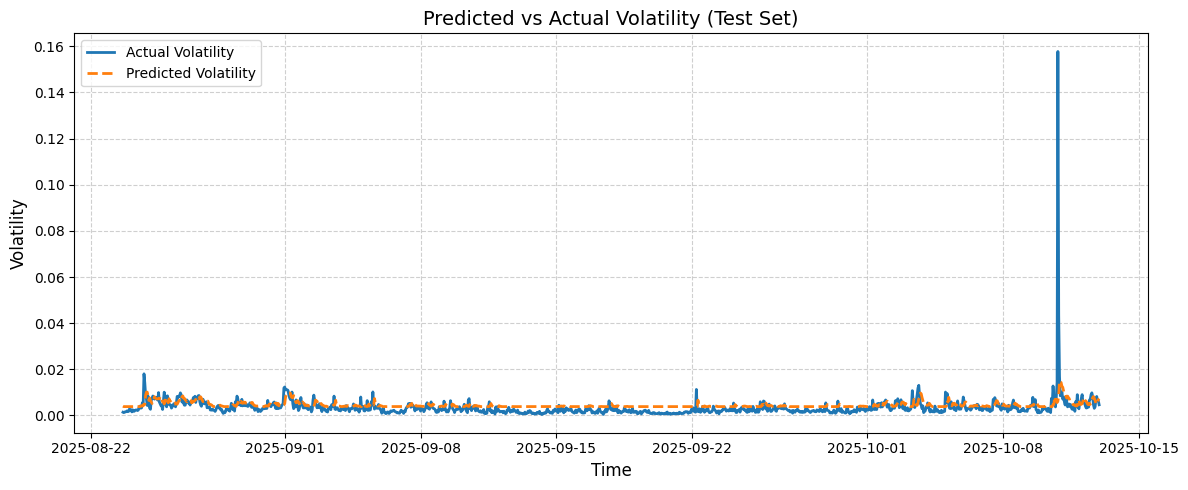

In [ ]:
# Plot results
plot_predicted_vs_actual(predictions_df)


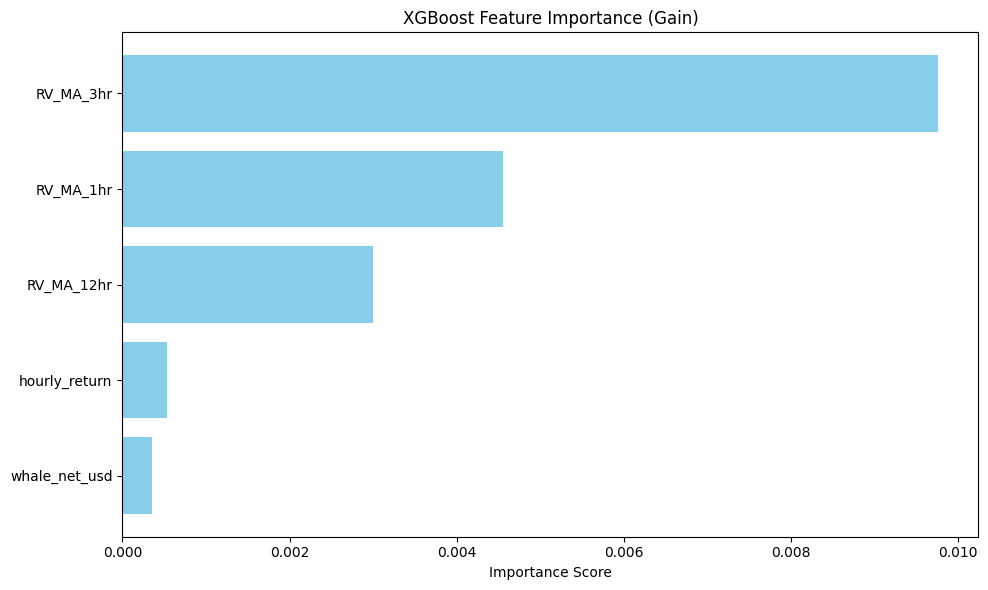

In [197]:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = (
    pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
    .sort_values('Importance', ascending=True)
)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title("XGBoost Feature Importance (Gain)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
